In [1]:
# encoding=utf8
import re
import random
import tarfile
import requests
import numpy as np
import paddle
from paddle.nn import Embedding
import paddle.nn.functional as F
from paddle.nn import LSTM, Embedding, Dropout, Linear

# 1、数据处理

In [2]:
train_file = 'data/Train.txt'
dic_file = 'data/dict.txt'

In [3]:
# 加载并查看数据
with open(train_file,'r',encoding='utf-8') as f:
    text = f.read().split('\n')
print(text[:5])
# 经过查看，测试文件中的一行代表一个样本，一条样本数据由三个部分组成，第一部分是类别对应的编码，第二部分是类别对应的中文名称，第三部分是样本的特征

['0\t财经\t上证50ETF净申购突增', '0\t财经\t交银施罗德保本基金将发行', '0\t财经\t基金公司不裁员反扩军 走访名校揽人才', '0\t财经\t基金巨亏30亿 欲打开云天系跌停自救', '0\t财经\t基金市场周二缩量走低']


In [4]:
# 字典文件是json格式，这种格式的数据由键值对组成，其中，第一个称为键，第二个称为值，在本次实验中，键表示一个字，值表示这个字的id

In [5]:
# 加载字典
word2id_dic = dict()
with open(dic_file,'r',encoding='utf-8') as f:
    text = f.read()
    word2id_dic = eval(text)
# 获取未编码数字id
unknown_word_id = word2id_dic['<unk>']
word2id_dic['<pad>'] = len(word2id_dic) # 表示非定长数据的填充

In [6]:
# 进行数据处理
# 该处理过程首先读取datafile中的文件，并利用dic字典，将其中的文本转为one-hot编码格式，同时，处理对应的label标签
train = []
classes = dict()
max_seq_len = 0
with open(train_file,'r',encoding='utf-8') as f:
    for line in f.readlines():
        line = line[:-1]
        sample = line.split('\t')
        sample[0] = int(sample[0])
        max_seq_len = max_seq_len if max_seq_len >= len(sample[2]) else len(sample[2])
        train.append(sample)
        if sample[0] not in classes:
            classes[sample[0]] = sample[1]
        elif sample[1] != classes[sample[0]]:
            raise Exception('{}类别对应到了不同的标签，请检查数据'.format(sample[1]))
train_set = []
for sample in train:
    encode_data = []
    for c in sample[2]:
        encode_data.append(word2id_dic.get(c,unknown_word_id))
    train_set.append((encode_data,int(sample[0])))
np.random.shuffle(train_set)

In [7]:
print('样本总量',len(train_set))

样本总量 752476


d:\python高级程序设计\.venv\lib\site-packages\matplotlib_inline\config.py:66: DeprecationWarning: InlineBackend._figure_formats_changed is deprecated in traitlets 4.1: use @observe and @unobserve instead.
  def _figure_formats_changed(self, name, old, new):
d:\python高级程序设计\.venv\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13]), array([ 33389,   6830,  18045, 138959,  29328,  37743, 146637,  45765,
        12032,  56778, 118444,   3221,  21936,  83369], dtype=int64))
科技 146637
星座 3221


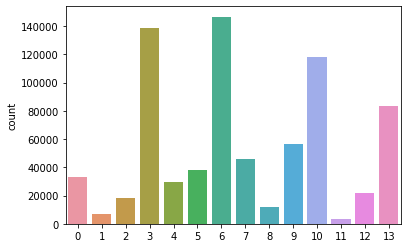

In [8]:
import seaborn as sns
labels = []
for i in train_set:
    labels.append(i[1])
sns.countplot(labels)
labels = np.array(labels).astype(np.int32)
labels = np.unique(labels,return_counts=True)
print(labels)
# 数据不平衡的情况比较严重
# 返回值最大、最小的索引位置
max = np.argmax(labels[1])
min = np.argmin(labels[1])
print(classes[max],labels[1][max]) #
print(classes[min],labels[1][min])
# 数据不平衡比较严重

In [9]:
x = [1,2,3,4]

x = [[x] for x in x]
x

[[1], [2], [3], [4]]

In [10]:
# 编写迭代器，每次按照batch_size的大小，返回样本量
def build_batch(data_set,batch_size = 128,max_seq_len = 128,shuffle = True):
    
    sentence_batch = [] # 代表一个mini-batch的句子
    sentence_label_batch = [] # 表示每个句子对应的分类

    if shuffle:
        np.random.shuffle(data_set)

    for sentence,label in data_set:
        sample = sentence[:]
        if len(sentence) < max_seq_len:
            for _ in range(max_seq_len-len(sample)):
                sample.append(word2id_dic['<pad>'])
        
        sample = [[word] for word in sample]
        sentence_batch.append(sample)
        sentence_label_batch.append([label])

        if len(sentence_batch) == batch_size:
            yield np.array(sentence_batch).astype(np.int64),np.array(sentence_label_batch).astype(np.int64)
            sentence_label_batch = []
            sentence_batch = []
    if len(sentence_batch) >= 0 and len(sentence_batch) <= batch_size:
        yield np.array(sentence_batch).astype(np.int64),np.array(sentence_label_batch).astype(np.int64)
    

# 定义网络结构

In [14]:
# 定义一个用于情感分类的网络实例，SentimentClassifier
class SentimentClassifier(paddle.nn.Layer):
    
    def __init__(self, hidden_size, vocab_size, embedding_size, class_num=2, num_steps=128, num_layers=1, init_scale=0.1, dropout_rate=None):
        
        # 参数含义如下：
        # 1.hidden_size，表示embedding-size，hidden和cell向量的维度
        # 2.vocab_size，模型可以考虑的词表大小
        # 3.embedding_size，表示词向量的维度
        # 4.class_num，情感类型个数，可以是2分类，也可以是多分类
        # 5.num_steps，表示这个情感分析模型最大可以考虑的句子长度
        # 6.num_layers，表示网络的层数
        # 7.dropout_rate，表示使用dropout过程中失活的神经元比例
        # 8.init_scale，表示网络内部的参数的初始化范围,长短时记忆网络内部用了很多Tanh，Sigmoid等激活函数，\
        # 这些函数对数值精度非常敏感，因此我们一般只使用比较小的初始化范围，以保证效果
        super(SentimentClassifier, self).__init__()
        self.hidden_size = hidden_size
        self.vocab_size = vocab_size
        self.embedding_size = embedding_size
        self.class_num = class_num
        self.num_steps = num_steps
        self.num_layers = num_layers
        self.dropout_rate = dropout_rate
        self.init_scale = init_scale
       
        # 声明一个LSTM模型，用来把每个句子抽象成向量
        self.simple_lstm_rnn = paddle.nn.LSTM(input_size=hidden_size, hidden_size=hidden_size, num_layers=num_layers)

        # 声明一个embedding层，用来把句子中的每个词转换为向量
        self.embedding = paddle.nn.Embedding(num_embeddings=vocab_size, embedding_dim=embedding_size, sparse=False, 
                                    weight_attr=paddle.ParamAttr(initializer=paddle.nn.initializer.Uniform(low=-init_scale, high=init_scale)))
        
        # 声明使用上述语义向量映射到具体情感类别时所需要使用的线性层
        self.cls_fc = paddle.nn.Linear(in_features=self.hidden_size, out_features=self.class_num, 
                             weight_attr=None, bias_attr=None)
        
        # 一般在获取单词的embedding后，会使用dropout层，防止过拟合，提升模型泛化能力
        self.dropout_layer = paddle.nn.Dropout(p=self.dropout_rate, mode='upscale_in_train')

    # forwad函数即为模型前向计算的函数，它有两个输入，分别为：
    # input为输入的训练文本，其shape为[batch_size, max_seq_len]
    # label训练文本对应的情感标签，其shape维[batch_size, 1]
    def forward(self, inputs):
        # 获取输入数据的batch_size
        batch_size = inputs.shape[0]

        # 本实验默认使用1层的LSTM，首先我们需要定义LSTM的初始hidden和cell，这里我们使用0来初始化这个序列的记忆
        init_hidden_data = np.zeros(
            (self.num_layers, batch_size, self.hidden_size), dtype='float32')
        init_cell_data = np.zeros(
            (self.num_layers, batch_size, self.hidden_size), dtype='float32')

        # 将这些初始记忆转换为飞桨可计算的向量，并且设置stop_gradient=True，避免这些向量被更新，从而影响训练效果
        init_hidden = paddle.to_tensor(init_hidden_data)
        init_hidden.stop_gradient = True
        init_cell = paddle.to_tensor(init_cell_data)
        init_cell.stop_gradient = True

        # 对应以上第2步，将输入的句子的mini-batch转换为词向量表示，转换后输入数据shape为[batch_size, max_seq_len, embedding_size]
        x_emb = self.embedding(inputs)
        x_emb = paddle.reshape(x_emb, shape=[-1, self.num_steps, self.embedding_size])
        # 在获取的词向量后添加dropout层
        if self.dropout_rate is not None and self.dropout_rate > 0.0:
            x_emb = self.dropout_layer(x_emb)
        
        # 对应以上第3步，使用LSTM网络，把每个句子转换为语义向量
        # 返回的last_hidden即为最后一个时间步的输出，其shape为[self.num_layers, batch_size, hidden_size]
        rnn_out, (last_hidden, last_cell) = self.simple_lstm_rnn(x_emb, (init_hidden, init_cell))
        # 提取最后一层隐状态作为文本的语义向量，其shape为[batch_size, hidden_size]
        last_hidden = paddle.reshape(last_hidden[-1], shape=[-1, self.hidden_size])

        # 对应以上第4步，将每个句子的向量表示映射到具体的情感类别上, logits的维度为[batch_size, 2]
        logits = self.cls_fc(last_hidden)
        
        return logits

In [17]:
# 定义训练参数
epoch_num = 5
batch_size = 128

learning_rate = 0.01
dropout_rate = 0.2
num_layers = 1
hidden_size = 256
embedding_size = 256
max_seq_len = max_seq_len
vocab_size = len(word2id_dic)

# 检测是否可以使用GPU，如果可以优先使用GPU
use_gpu = True if paddle.get_device().startswith("gpu") else False
if use_gpu:
    print('use_gpu')
    paddle.set_device('gpu:0')

# 实例化模型
sentiment_classifier = SentimentClassifier(hidden_size, vocab_size, embedding_size,class_num=14,  num_steps=max_seq_len, num_layers=num_layers, dropout_rate=dropout_rate)

# 指定优化策略，更新模型参数
optimizer = paddle.optimizer.Adam(learning_rate=learning_rate, beta1=0.9, beta2=0.999, parameters= sentiment_classifier.parameters()) 

# 定义训练函数
# 记录训练过程中的损失变化情况，可用于后续画图查看训练情况
losses = []
steps = []

def train(model):
    # 开启模型训练模式
    model.train()

    for epoch_id in range(epoch_num):
        # 建立训练数据生成器，每次迭代生成一个batch，每个batch包含训练文本和文本对应的情感标签
        train_loader = build_batch(train_set, batch_size, max_seq_len)
        
        for step, (sentences, labels) in enumerate(train_loader):
            # 获取数据，并将张量转换为Tensor类型
            sentences = paddle.to_tensor(sentences)
            labels = paddle.to_tensor(labels)
            
            # 前向计算，将数据feed进模型，并得到预测的情感标签和损失
            logits = model(sentences)

            # 计算损失
            loss = F.cross_entropy(input=logits, label=labels, soft_label=False)
            loss = paddle.mean(loss)

            # 后向传播
            loss.backward()
            # 更新参数
            optimizer.step()
            # 清除梯度
            optimizer.clear_grad()

            if step % 10 == 0:
                # 记录当前步骤的loss变化情况
                losses.append(loss.numpy()[0])
                steps.append(step)
                # 打印当前loss数值
                print("step %d, loss %.3f" % (step, loss.numpy()[0]))

#训练模型
train(sentiment_classifier)

# 保存模型，包含两部分：模型参数和优化器参数
model_name = "sentiment_classifier"
# 保存训练好的模型参数
paddle.save(sentiment_classifier.state_dict(), "{}.pdparams".format(model_name))
# 保存优化器参数，方便后续模型继续训练
paddle.save(optimizer.state_dict(), "{}.pdopt".format(model_name))

step 0, loss 2.627
step 10, loss 2.376
step 20, loss 2.339
step 30, loss 2.204
step 40, loss 2.280
step 50, loss 2.312
step 60, loss 2.297
step 70, loss 2.522
step 80, loss 2.418
step 90, loss 2.175
step 100, loss 2.272
step 110, loss 2.274
step 120, loss 2.290
step 130, loss 2.345
step 140, loss 2.210
step 150, loss 2.163
step 160, loss 2.255
step 170, loss 2.152
step 180, loss 2.267
step 190, loss 2.348
step 200, loss 2.269
step 210, loss 2.241
step 220, loss 2.234
step 230, loss 2.200
step 240, loss 2.242
step 250, loss 2.226
step 260, loss 2.364
step 270, loss 2.274
step 280, loss 2.329
step 290, loss 2.254
step 300, loss 2.313
step 310, loss 2.242
step 320, loss 2.211
step 330, loss 2.323
step 340, loss 2.382
step 350, loss 2.292
step 360, loss 2.272
step 370, loss 2.232


KeyboardInterrupt: 

In [119]:
class NewsClassifier(paddle.nn.Layer):
    def __init__(self,hidden_size, vocab_size, embedding_size, class_num=14, num_steps=128, num_layers=1, init_scale=0.1, dropout_rate=None):
        super(NewsClassifier,self).__init__()

        # 有哪些参数??
        # 1.词向量的行-也就是单词的个数
        # 2.词向量的列-也就是词向量的维度
        # 3.lstm输入层、cell的维度

        # 参数含义如下：
        # 1.hidden_size，表示embedding-size，hidden和cell向量的维度,同时也是输入的维度
        # 2.vocab_size，模型可以考虑的词表大小
        # 3.embedding_size，表示词向量的维度
        # 4.class_num，新闻分类的个数，可以是2分类，也可以是多分类
        # 5.num_steps，表示这个新闻分类的模型最大可以考虑的句子长度
        # 6.num_layers，表示网络的层数
        # 7.dropout_rate，表示使用dropout过程中失活的神经元比例
        # 8.init_scale，表示网络内部的参数的初始化范围,长短时记忆网络内部用了很多Tanh，Sigmoid等激活函数，\
        # 这些函数对数值精度非常敏感，因此我们一般只使用比较小的初始化范围，以保证效果
        self.hidden_size = hidden_size
        self.vocab_size = vocab_size
        self.embedding_size = embedding_size
        self.class_num = class_num
        self.num_steps = num_steps
        self.num_layers = num_layers
        self.dropout_rate = dropout_rate
        self.init_scale = init_scale

        # 声明一个embedding层，用来把句子中的每个词转换为向量
        # num_embeddings 定义了词表的大小，也就是字典的大小
        # embedding_dim 定义了词向量的维度
        self.embedding = paddle.nn.Embedding(num_embeddings=vocab_size, embedding_dim=embedding_size, sparse=False, 
                                    weight_attr=paddle.ParamAttr(initializer=paddle.nn.initializer.Uniform(low=-init_scale, high=init_scale)))
        
        # 一般在获取单词的embedding后，会使用dropout层，防止过拟合，提升模型泛化能力
        self.dropout_layer = paddle.nn.Dropout(p=self.dropout_rate, mode='upscale_in_train')
        
        # 声明一个LSTM模型，用来把每个句子抽象成向量
        # hidden_size 表示隐层的数量，也就是权重矩阵的行；那么，权重矩阵的列数量必须为hidden_size，否则无法进行矩阵运算
        # input_size 表示输入向量的维度，需要和embedding层的向量维度相同
        self.simple_lstm_rnn = paddle.nn.LSTM(input_size=hidden_size, hidden_size=hidden_size, num_layers=num_layers)
        
        # 将LSTM最后一次输出作为全连接的输入
        # 声明使用上述语义向量映射到具体情感类别时所需要使用的线性层
        self.cls_fc = paddle.nn.Linear(in_features=self.hidden_size, out_features=self.class_num, 
                             weight_attr=None, bias_attr=None)



    def foward(self,inputs,shape = False):
        batch_size = input.shape[0]

        # 初始化隐层和cell的参数，初始化为0，表示空白的记忆
        # 本实验默认使用1层的LSTM，首先我们需要定义LSTM的初始hidden和cell，这里我们使用0来初始化这个序列的记忆
        init_hidden_data = np.zeros(
            (self.num_layers, batch_size, self.hidden_size), dtype='float32') # num_layers表示LSTM有多少层，batch_size表示有多少个隐层，hidden_size表示隐层的维度
        init_cell_data = np.zeros(
            (self.num_layers, batch_size, self.hidden_size), dtype='float32')

        # 将这些初始记忆转换为飞桨可计算的向量，并且设置stop_gradient=True，避免这些向量被更新，从而影响训练效果
        init_hidden = paddle.to_tensor(init_hidden_data)
        init_hidden.stop_gradient = True
        init_cell = paddle.to_tensor(init_cell_data)
        init_cell.stop_gradient = True

        # 将输入的句子的mini-batch转换为词向量表示，转换后输入数据shape为[batch_size, max_seq_len, embedding_size]
        # 一个单词一个行
        x_emb = self.embedding(inputs)
        x_emb = paddle.reshape(x_emb, shape=[-1, self.num_steps, self.embedding_size]) # 如果不是定长的话，也可以shape = [batch_size,-1,self.embedding_size]
        
        # 在获取的词向量后添加dropout层
        if self.dropout_rate is not None and self.dropout_rate > 0.0:
            x_emb = self.dropout_layer(x_emb)
        
        # 使用LSTM网络，把每个句子转换为语义向量
        # 返回的last_hidden即为最后一个时间步的输出，其shape为[self.num_layers, batch_size, hidden_size]
        rnn_out, (last_hidden, last_cell) = self.simple_lstm_rnn(x_emb, (init_hidden, init_cell)) # 表示输入、init_hidden、init_cell
        
        # 提取最后一层隐状态作为文本的语义向量，其shape为[batch_size, hidden_size]
        last_hidden = paddle.reshape(last_hidden[-1], shape=[-1, self.hidden_size])

        # 对应以上第4步，将每个句子的向量表示映射到具体的情感类别上, logits的维度为[batch_size, 2]
        logits = self.cls_fc(last_hidden)

        if shape:
            print(self.embedding.shape)
            print(self.simple_lstm_rnn.shape)
        
        return logits

       
        

In [120]:
# 定义训练参数
epoch_num = 5
# 批大小
batch_size = 128

# 学习率
learning_rate = 0.01
# drouout层随机丢去的权重
dropout_rate = 0.2
# 设置lstm的层数，这里先设置为1
num_layers = 1
# 这是隐层的大小
hidden_size = 256
embedding_size = 256
max_seq_len = max_seq_len
vocab_size = len(word2id_dic)

# 检测是否可以使用GPU，如果可以优先使用GPU
use_gpu = True if paddle.get_device().startswith("gpu") else False
if use_gpu:
    paddle.set_device('gpu:0')

# 实例化模型
sentiment_classifier = NewsClassifier(hidden_size, vocab_size, embedding_size,  num_steps=max_seq_len, num_layers=num_layers, dropout_rate=dropout_rate)

# 指定优化策略，更新模型参数
optimizer = paddle.optimizer.Adam(learning_rate=learning_rate, beta1=0.9, beta2=0.999, parameters= sentiment_classifier.parameters()) 

# 定义训练函数
# 记录训练过程中的损失变化情况，可用于后续画图查看训练情况
losses = []
steps = []

def train(model):
    # 开启模型训练模式
    model.train()
    
    # 建立训练数据生成器，每次迭代生成一个batch，每个batch包含训练文本和文本对应的情感标签
    
    
    for epoch_id in range(epoch_num):
        train_loader = build_batch(train_set, batch_size, max_seq_len)
        for step, (sentences, labels) in enumerate(train_loader):
            # 获取数据，并将张量转换为Tensor类型
            sentences = paddle.to_tensor(sentences)
            labels = paddle.to_tensor(labels)
            
            # 前向计算，将数据feed进模型，并得到预测的情感标签和损失
            logits = model(sentences)

            print('ddd')
            # 计算损失
            loss = F.cross_entropy(input=logits, label=labels, soft_label=False)
            loss = paddle.mean(loss)

            # 后向传播
            loss.backward()
            # 更新参数
            optimizer.step()
            # 清除梯度
            optimizer.clear_grad()

            if step % 100 == 0:
                # 记录当前步骤的loss变化情况
                losses.append(loss.numpy()[0])
                steps.append(step)
                # 打印当前loss数值
                print("step %d, loss %.3f" % (step, loss.numpy()[0]))

#训练模型
train(sentiment_classifier)

# 保存模型，包含两部分：模型参数和优化器参数
model_name = "sentiment_classifier"
# 保存训练好的模型参数
paddle.save(sentiment_classifier.state_dict(), "{}.pdparams".format(model_name))
# 保存优化器参数，方便后续模型继续训练
paddle.save(optimizer.state_dict(), "{}.pdopt".format(model_name))

NotImplementedError: 